# 딥러닝의 기본 이미지 분류하기
## Chapter 5 자연 풍경 이미지 분류하기

In [ ]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#reading files
import os
import scipy.io as sio
import cv2
from torch.utils.data import Dataset, DataLoader

#plots
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import randrange

#model
import torch
from torch import nn, optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

# metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [ ]:
seed = 827
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 5.1 데이터 분석

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/프로젝트로\ 시작하는\ Pytorch/5.5
%ls

/content/drive/MyDrive/Colab Notebooks/프로젝트로 시작하는 Pytorch/5.5
best.pth  dataset/  MIML.zip  scene_label1.h5  wandb/


In [ ]:
!unzip -qq MIML.zip -d dataset

In [ ]:
ls dataset

'miml data.mat'   miml-image-data/   original/


In [ ]:
ls dataset/miml-image-data

original/  original.rar  processed/  processed.rar


In [ ]:
#base directory
base_dir = 'dataset/miml-image-data'
image_dir = os.path.join(base_dir, 'original')

mat_file_path = os.path.join(base_dir, 'processed/miml data.mat')
mat_file = sio.loadmat(mat_file_path)

#target labels
target_array = mat_file['targets'].T
target_list = [[j if j==1 else 0 for j in row] for row in target_array]

#class
class_names = [j[0][0] for j in mat_file['class_name']]

print("number of samples:", len(target_list))
print('target: ', target_list[425])
print('class: ', class_names)

number of samples: 2000
target:  [0, 1, 1, 0, 0]
class:  ['desert', 'mountains', 'sea', 'sunset', 'trees']


[409 458 580 465 560]


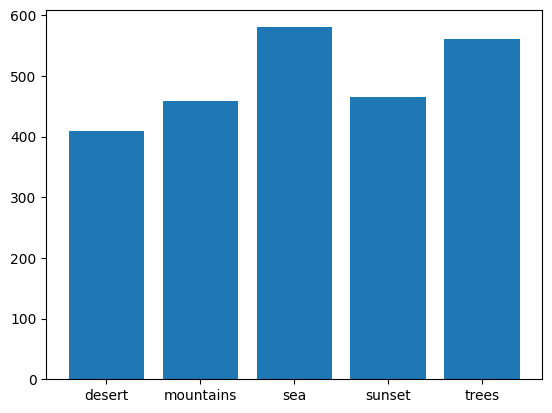

In [ ]:
num_classes = np.sum(target_list, axis=0)
plt.bar(class_names, num_classes)
print(num_classes)

[1543  442   15]


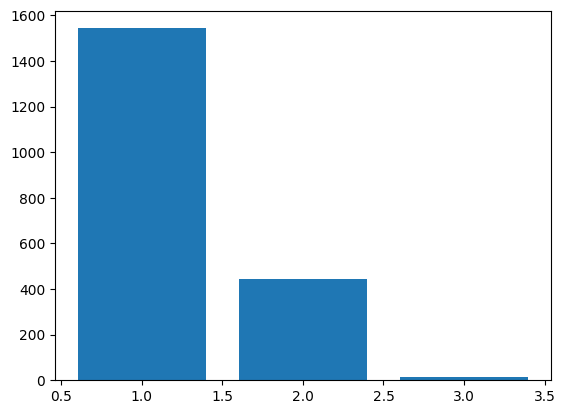

In [ ]:
counts, num = np.unique(np.sum(target_list, axis=1), return_counts=True)
plt.bar(counts, num)
print(num)

In [ ]:
avg_label_pre_image = np.sum(counts * num) / len(target_list)
avg_label_pre_image

1.236

### 5.2 데이터셋

In [ ]:
class SceneDataset(Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform

    mat_file_path = os.path.join(root, 'processed/miml data.mat')
    mat_file = sio.loadmat(mat_file_path)
    target_array = mat_file['targets'].T

    self.targets = [[j if j==1 else 0 for j in row] for row in target_array]
    self.images = [
      os.path.join(root, f'original/{a+1}.jpg')
      for a in range(len(self.targets))
    ]

    self.class_names = [j[0][0] for j in mat_file['class_name']]

  def __getitem__(self, index):
    path, target = self.images[index], self.targets[index]

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transform is not None:
      augmented = self.transform(image=image)
      image = augmented["image"]

    return image, torch.tensor(target)

  def __len__(self):
    return len(self.targets)

  def target2class(self, target):
    return [self.class_names[i] for i, v in enumerate(target) if v == 1]

In [ ]:
def get_dataset(
  root, train=0.8, val=0.1,
  train_transforms=None, test_transforms=None,
  random_seed=827
):
  origin = SceneDataset(
    root,
    transform=train_transforms
  )

  train_samples = int(len(origin) * train)
  val_samples = int(len(origin) * val)
  test_samples = len(origin) - train_samples - val_samples

  torch.manual_seed(random_seed)
  trainset, valset, testset = torch.utils.data.random_split(
    origin,
    (train_samples, val_samples, test_samples),
  )
  valset.transforms = test_transforms
  testset.transforms = test_transforms

  return trainset, valset, testset

trainset, valset, testset = get_dataset(base_dir)
print(len(trainset), len(valset), len(testset))

1600 200 200


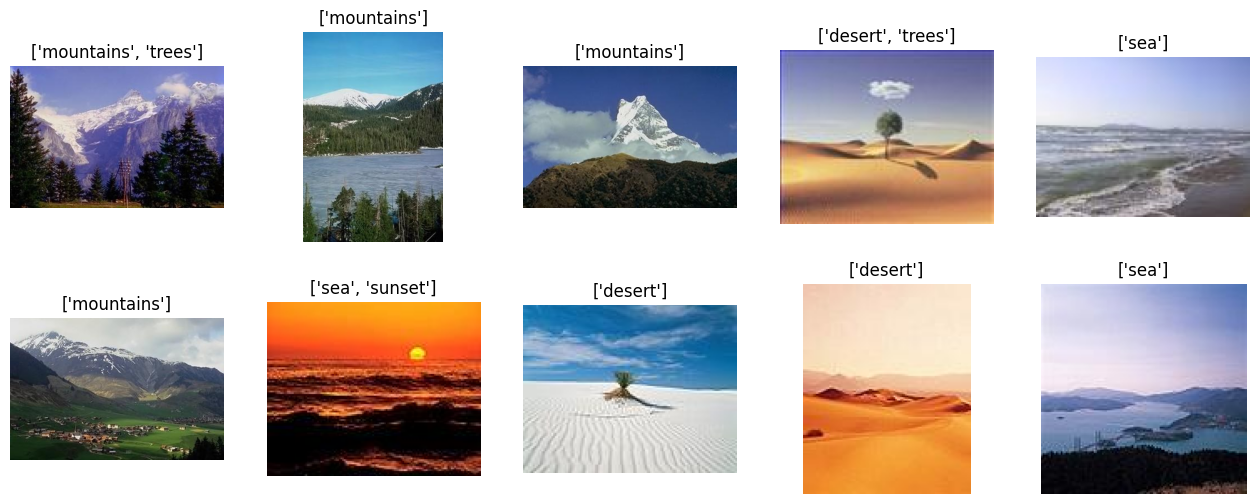

In [ ]:
plt.figure(figsize=(16,6))
for i, data in enumerate(trainset):
  image, label = data

  plt.subplot(2,5,i+1)
  plt.imshow(image)
  plt.title(trainset.dataset.target2class(label))
  plt.axis('off')

  if i >= 9:
    break

### 5.3 ResNet18 모델

In [ ]:
!pip install -q torchinfo

In [ ]:
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights

from torchinfo import summary


def load_resnet(classes):
  model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(in_features=512, out_features=classes, bias=True)

  return model
summary(load_resnet(5), (1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

### 5.4 모델 학습

In [ ]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  with tqdm(dataloader) as pbar:
    for i, (data, targets) in enumerate(pbar):
      data, targets = data.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, targets.float()) #### Change
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(loss=loss.item())

      # Accuracy 계산
      with torch.no_grad():
        predicted = torch.sigmoid(outputs).round()
        correct += torch.all(torch.eq(predicted, targets), dim=-1).sum() #### Change

    # Accuracy 출력
    data_num = len(dataloader.dataset)
    acc = 100. * correct / data_num
    print(
        f"[{epoch}/{EPOCH}]",
        f"train loss: {running_loss/len(dataloader):.4f}",
        f"train acc: {correct}/{data_num} ({acc:.2f}%)"
    )

  return running_loss/len(dataloader), acc

In [ ]:
def validation(model, dataloader, criterion, epoch, device):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets.float()) #### Change

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

        # Accuracy 계산
        predicted = torch.sigmoid(outputs).round()
        correct += torch.all(torch.eq(predicted, targets), dim=-1).sum() #### Change

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader), acc

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

wandb.init(project="Natural Scene", save_code=True)

EPOCH = 10
BATCH_SIZE = 128
NUM_WORKERS = 1
LR = 0.001

wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCH,
  "batch_size": BATCH_SIZE,
  "num_workers": NUM_WORKERS
}

train_transform = A.Compose([
  A.Resize(256, 256),
  A.Rotate(limit=(-20, +20)),
  A.RandomCrop(224, 224),
  A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
  ToTensorV2(),
])
test_transform = A.Compose([
  A.Resize(256, 256),
  A.CenterCrop(224, 224),
  A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
  ToTensorV2(),
])

trainset, valset, testset = get_dataset(
  base_dir,
  train_transforms=train_transform,
  test_transforms=test_transform
)

# dataloader
train_loader = DataLoader(
  dataset=trainset,
  shuffle=True,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
  dataset=testset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)

# Model
model = load_resnet(5)

# Optimizer, Loss, Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model = model.to(device)
criterion = criterion.to(device)

max_acc = 0
# Start Training
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  wandb.log({
      "lr": scheduler.get_last_lr()[0],
      "train_loss": tloss,
      "train_accuracy": tacc,
      "val_loss": vloss,
      "val_acc": vacc
  })
  scheduler.step()

  if vacc > max_acc:
    torch.save(model.state_dict(), "best.pth")

# load best model
model.load_state_dict(torch.load("best.pth"))
artifact = wandb.Artifact('best', type='checkpoint')
artifact.add_file('best.pth')
wandb.log_artifact(artifact)

LR: [0.001]


100%|██████████| 13/13 [07:40<00:00, 35.39s/it, loss=0.236]


[0/10] train loss: 0.3026 train acc: 876/1600 (54.75%)


100%|██████████| 2/2 [01:33<00:00, 46.93s/it, loss=0.774]


[0/10] valid loss: 0.7961 valid acc: 110/200 (55.00%)

LR: [0.001]


100%|██████████| 13/13 [00:10<00:00,  1.30it/s, loss=0.171]


[1/10] train loss: 0.1831 train acc: 1151/1600 (71.94%)


100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.319]


[1/10] valid loss: 0.3030 valid acc: 122/200 (61.00%)

LR: [0.001]


100%|██████████| 13/13 [00:09<00:00,  1.44it/s, loss=0.141]


[2/10] train loss: 0.1458 train acc: 1212/1600 (75.75%)


100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.442]


[2/10] valid loss: 0.3686 valid acc: 113/200 (56.50%)

LR: [0.0005]


100%|██████████| 13/13 [00:10<00:00,  1.27it/s, loss=0.101]


[3/10] train loss: 0.0928 train acc: 1371/1600 (85.69%)


100%|██████████| 2/2 [00:01<00:00,  1.64it/s, loss=0.241]


[3/10] valid loss: 0.2076 valid acc: 138/200 (69.00%)

LR: [0.0005]


100%|██████████| 13/13 [00:10<00:00,  1.28it/s, loss=0.0793]


[4/10] train loss: 0.0661 train acc: 1439/1600 (89.94%)


100%|██████████| 2/2 [00:01<00:00,  1.68it/s, loss=0.225]


[4/10] valid loss: 0.1895 valid acc: 148/200 (74.00%)

LR: [0.0005]


100%|██████████| 13/13 [00:09<00:00,  1.34it/s, loss=0.0747]


[5/10] train loss: 0.0505 train acc: 1468/1600 (91.75%)


100%|██████████| 2/2 [00:01<00:00,  1.23it/s, loss=0.206]


[5/10] valid loss: 0.1803 valid acc: 151/200 (75.50%)

LR: [0.00025]


100%|██████████| 13/13 [00:09<00:00,  1.43it/s, loss=0.0823]


[6/10] train loss: 0.0378 train acc: 1520/1600 (95.00%)


100%|██████████| 2/2 [00:01<00:00,  1.63it/s, loss=0.219]


[6/10] valid loss: 0.1841 valid acc: 152/200 (76.00%)

LR: [0.00025]


100%|██████████| 13/13 [00:10<00:00,  1.29it/s, loss=0.0432]


[7/10] train loss: 0.0273 train acc: 1548/1600 (96.75%)


100%|██████████| 2/2 [00:01<00:00,  1.59it/s, loss=0.225]


[7/10] valid loss: 0.1886 valid acc: 153/200 (76.50%)

LR: [0.00025]


100%|██████████| 13/13 [00:10<00:00,  1.25it/s, loss=0.0316]


[8/10] train loss: 0.0208 train acc: 1565/1600 (97.81%)


100%|██████████| 2/2 [00:01<00:00,  1.68it/s, loss=0.258]


[8/10] valid loss: 0.1954 valid acc: 155/200 (77.50%)

LR: [0.000125]


100%|██████████| 13/13 [00:09<00:00,  1.36it/s, loss=0.0302]


[9/10] train loss: 0.0175 train acc: 1573/1600 (98.31%)


100%|██████████| 2/2 [00:01<00:00,  1.27it/s, loss=0.214]


[9/10] valid loss: 0.1770 valid acc: 154/200 (77.00%)



<Artifact best>

In [ ]:
def get_probs_trues(dataset, model, device):
  probs, trues = [], []
  for data, label in dataset:
    logit = model(data.unsqueeze(0).to(device))
    probs.append(torch.sigmoid(logit).detach().squeeze().cpu())
    trues.append(label.detach().squeeze().cpu())
  return torch.stack(probs), torch.stack(trues)

In [ ]:
def get_best_thresholds(y_probs, y_trues):
  threshold = np.arange(0.1, 0.9, 0.05)
  best_threshold = np.zeros(y_probs.shape[1])
  for i in range(y_probs.shape[1]):
    f1 = []
    y_prob = np.array(y_probs[:,i])
    for j in threshold:
      y_pred = [1 if prob >= j else 0 for prob in y_prob]
      f1.append(f1_score(y_trues[:,i], y_pred))
    f1   = np.array(f1)
    index = np.where(f1 == f1.max())
    best_threshold[i] = threshold[index][0]
  return best_threshold

In [ ]:
y_probs, y_trues = get_probs_trues(valset, model, device)
class_names = testset.dataset.class_names

best_threshold = get_best_thresholds(y_probs, y_trues)

for i in range(5):
  print(f"{class_names[i]}: {best_threshold[i]:.2f}")

wandb.log({
  "best_threshold": wandb.Table(
    columns=[str(class_names[i]) for i in range(5)],
    data=best_threshold.reshape(1,-1)
  )
})

desert: 0.5000000000000001
mountains: 0.5000000000000001
sea: 0.8000000000000002
sunset: 0.20000000000000004
trees: 0.5000000000000001


### 5.5 정확도/정밀도/재현율/F1 스코어
그리고 혼돈 행렬(Confusion matrix)

### 5.6 테스트

In [ ]:
def get_pred(y_test, y_proba, threshold):
  y_pred = np.array([[1 if y_proba[i, j] >= threshold[j] else 0
                      for j in range(y_test.shape[1])]
                      for i in range(y_test.shape[0])])
  return y_pred

In [ ]:
# y_probs, y_true = get_probs_trues(testset, model, device)
y_pred = get_pred(y_true, y_probs, best_threshold)

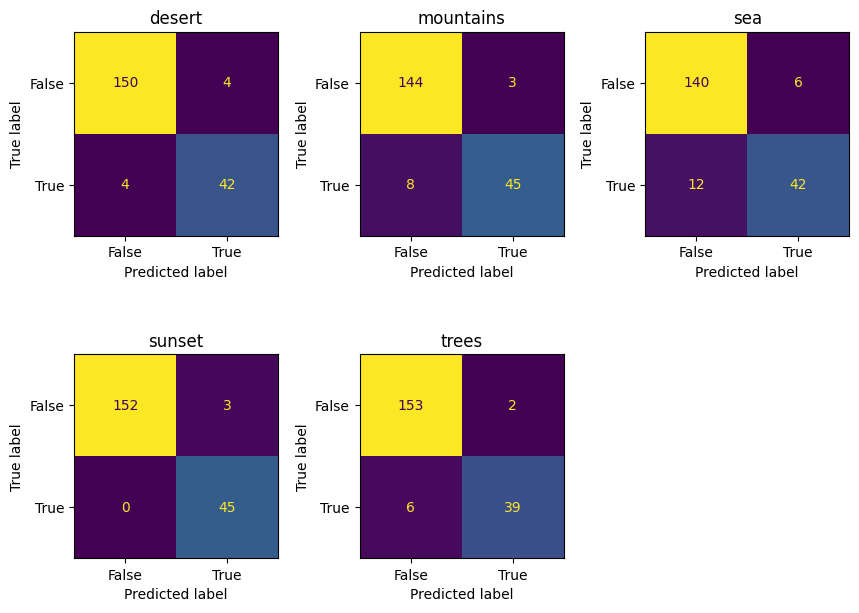

In [ ]:
y_pred = get_pred(y_true, y_probs, best_threshold)

f, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.ravel()
for i in range(5):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i],
                                                 y_pred[:, i]),
                                display_labels=["False", "True"])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title(class_names[i])
  disp.im_.colorbar.remove()
axes[5].axis("off")
plt.subplots_adjust(wspace=0.4, hspace=0.1)

#### Classification Report

In [ ]:
report = classification_report(y_pred, y_true,
                               target_names=class_names,
                               output_dict=True
                              )
wandb.log({
  "report": wandb.Table(
      dataframe=pd.DataFrame(report).T.reset_index(),
      allow_mixed_types=True
    )
})

#### Prediction Samples

lr,███▄▄▄▂▂▂▁
train_accuracy,▁▄▄▆▇▇▇███
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▃▁▅▇▇████
val_loss,█▂▃▁▁▁▁▁▁▁
lr,0.00013
train_accuracy,98.3125
train_loss,0.01754
val_acc,77.0
val_loss,0.17698


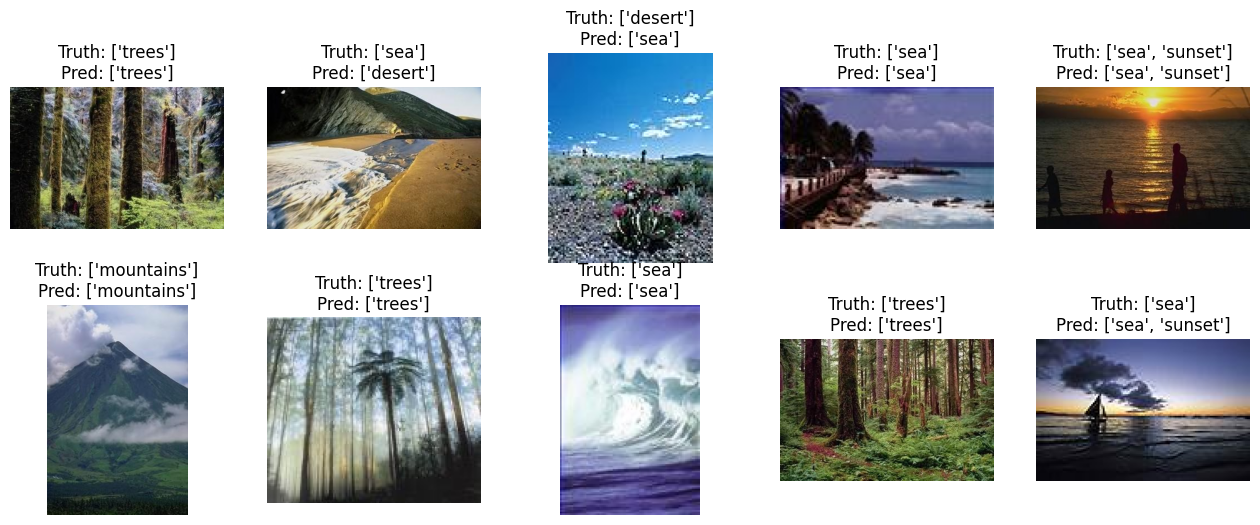

In [ ]:
testset.dataset.transform = None

plt.figure(figsize=(16,6))
for i, data in enumerate(testset):
  image, label = data

  truth = testset.dataset.target2class(label)
  pred = testset.dataset.target2class(y_pred[i])

  plt.subplot(2,5,i+1)
  plt.imshow(image)
  plt.title(f'Truth: {truth}\nPred: {pred}')
  plt.axis('off')

  if i >= 9:
    break

wandb.log({"testset prediction samples": plt})
wandb.finish()